In [1]:
# import packages
import json
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# Load file with user behaviour
user_behaviour = pd.read_csv(os.path.join(os.getcwd(), "new_user_info.csv"))

In [3]:
# Inspect user behaviour file
user_behaviour.head()

id persona gender  starting_show  liked_shows  disliked_shows  \
0   0       D      F            861        681.0           521.0   
1   0       D      F            861        185.0           504.0   
2   0       D      F            861         67.0           442.0   
3   0       D      F            861         96.0           510.0   
4   0       D      F            861        451.0          1056.0   

   also_clicked_shows      genre_1 genre_2    genre_3    genre_4  \
0                 139  Documentary   Drama  Education  Lifestyle   
1                 828  Documentary   Drama  Education  Lifestyle   
2                 748  Documentary   Drama  Education  Lifestyle   
3                 560  Documentary   Drama  Education  Lifestyle   
4                 974  Documentary   Drama  Education  Lifestyle   

                    genre_5      value  
0  News and current affairs  Diversity  
1  News and current affairs  Diversity  
2  News and current affairs  Diversity  
3  News and current affairs  Diversity  
4  News and current affairs  Diversity

In [4]:
# Load and inspect file with shows
df_shows = pd.read_csv(os.path.join(os.getcwd(), 'clustered_representation_shows.csv'), sep=',')
df_shows.head()

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  id  \
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0   
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1   
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2   
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3   
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4   

                                enriched_description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

   enriched_description_length  k_means_cluster  gender_bias  \
0                           36               11    -0.020405   
1                           38               11    -0.019051   
2                          856               13    -0.006951   
3                           39                4     0.000000   
4                          456               12    -0.020988   

   representation_diverse  indigenous_representation  bipoc_representation  \
0                       0                          0                     0   
1                       0                          0                     0   
2                       1                          0                     1   
3                       0                          0                     0   
4                       0                          0                     0   

   lgbtq_representation  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [5]:
# Group by user id to be able to easily get the shows each user liked
grouped_users = user_behaviour.groupby(['id'])

In [6]:
user_ids = []
liked_shows = []
disliked_shows = []
clicked_shows = []
# Loop through the grouped users and retrieve each their id and liked shows
for user_id, user in tqdm(grouped_users, total=1000):
    # Create a list with the ids of users
    user_ids.append(user_id)
    
    # Create a set with unique show ids that the user (dis)liked or just clicked on
    # Make sure to remove the NaN values (due to more shows clicked on than (dis)liked)
    user_likes = [show for show in list(user.liked_shows) if pd.isnull(show)==False]
    liked_shows.append(set(user_likes))
    
    user_dislikes = [show for show in list(user.disliked_shows) if pd.isnull(show)==False]
    disliked_shows.append(set(user_dislikes))
    
    user_clicks = set(user.also_clicked_shows)
    clicked_shows.append(user_clicks)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# Users also clicked on the shows they liked and disliked, so append these to the clicked_shows list
clicked_shows = clicked_shows + liked_shows + disliked_shows

In [8]:
user_similarities = []
# Compute Jaccard similarity between users based on the shows they liked, disliked, and clicked 
for id_user_a, likes_user_a, dislikes_user_a, clicks_user_a in tqdm(zip(user_ids, liked_shows, disliked_shows, clicked_shows), total=len(user_ids)):
    for id_user_b, likes_user_b, dislikes_user_b, clicks_user_b in zip(user_ids, liked_shows, disliked_shows, clicked_shows):
        # Also compute similarity to user itself because when calculating the probability that a user likes a movie,
        # it is of course much more likely when they already liked/watched it before
        if id_user_a == id_user_b:
            similarity = 1 # Maximum Jaccard similarity is 1, which is the case for comparing a user with themself
        else:
            # Compute Jaccard similarity between user a and b
            numerator = (len(likes_user_a.intersection(likes_user_b)) +  # Shows liked by both
                        len(dislikes_user_a.intersection(dislikes_user_b)) +  # Shows disliked by both
                        len(clicks_user_a.intersection(clicks_user_b)) -  # Shows clicked by both (whether liked or disliked)
                        len(likes_user_a.intersection(dislikes_user_b)) -  # Shows liked by a and disliked by b
                        len(dislikes_user_a.intersection(likes_user_b))) # Shows liked by b and disliked by a
                
            denominator = len(clicks_user_a.union(clicks_user_b)) # All shows that are (dis)liked are subset of clicks
            similarity = numerator / (denominator + 1e-8) # Add small number to prevent division by 0
        user_similarities.append([id_user_a, id_user_b, similarity])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# Create pandas dataframe from user_similarities and save it
# Note that with e.g. 10k users, one gets 10k*10k rows, which gave a memory issue with creating dataframe
# So instead can just continue with computing how well someone will like a show using the list (even though
# takes way too long as well, or go with less users)
df_user_similarities = pd.DataFrame(user_similarities, columns=['id_user_a', 'id_user_b', 'jaccard_similarity'])
df_user_similarities.to_csv(os.path.join(os.getcwd(), 'user_jaccard_similarities.csv'), 
                                 index=False, sep=',')

In [10]:
# Write user similarities list to a .txt file if dataframe didn't work due to memory issues
with open('user_sim.txt', 'w') as f:
    for item in user_similarities:
        f.write("%s\n" % item)

In [11]:
df_user_similarities = pd.read_csv(os.path.join(os.getcwd(), "user_jaccard_similarities.csv"))

In [12]:
# Inspect dataframe with user similarities based on their watching behaviour
df_user_similarities.head()

id_user_a  id_user_b  jaccard_similarity
0          0          0            1.000000
1          0          1            0.029851
2          0          2            0.028986
3          0          3            0.000000
4          0          4            0.029412

In [13]:
likes_user_ids = []
dislikes_user_ids = []
clicks_user_ids = []
# For each show determine the ids of the users who liked it 
for show_id in tqdm(df_shows.id.values, total=len(df_shows)):
    # Get the liked_shows indices of rows where that user liked this movie
    likes_indices = [i for i, likes in enumerate(liked_shows) if show_id in likes]
    
    # Get the disliked_shows indices of rows where that user liked this movie
    dislikes_indices = [i for i, dislikes in enumerate(disliked_shows) if show_id in dislikes]
    
    # Get the clicked_shows indices of rows where that user liked this movie
    clicks_indices = [i for i, clicks in enumerate(clicked_shows) if show_id in clicks]

    # Get the ids of users who liked this movie (if none did, then return [])
    if likes_indices:
        likes_ids = [user_id for i, user_id in enumerate(user_ids) if i in likes_indices]
    else:
        likes_ids = []
    likes_user_ids.append(likes_ids)
    
    # Get the ids of users who disliked this movie (if none did, then return [])
    if dislikes_indices:
        dislikes_ids = [user_id for i, user_id in enumerate(user_ids) if i in dislikes_indices]
    else:
        dislikes_ids = []
    dislikes_user_ids.append(dislikes_ids)
    
    # Get the ids of users who clicked this movie (if none did, then return [])
    if clicks_indices:
        clicks_ids = [user_id for i, user_id in enumerate(user_ids) if i in clicks_indices]
    else:
        clicks_ids = []
    clicks_user_ids.append(clicks_ids)

  0%|          | 0/1068 [00:00<?, ?it/s]

In [14]:
show_likelihood = []
# Determine for each user the probability they like each movie
for i, user_id in tqdm(enumerate(user_ids), total=len(user_ids)):
    # Get the similarities between this user and all other users
    # There are sequentially 1000 similarities with all other users so make use of that structure
    # to efficiently get user's similarities as otherwise looping through full similarities list to
    # see if id_user_a is equal to user_id takes very long (especially if many users)
    user_sim = df_user_similarities.iloc[0+i*1000:1000+i*1000] 
    # user_sim = [user_lst for user_lst in user_similarities if user_lst[0] == user_id] # If no dataframe was possible to make
    # user_sim = df_user_similarities[df_user_similarities.id_user_a == user_id] # If dataframe was possible to make
    
    # Loop through each show: get its show id and the ids of users that liked, disliked, or clicked it
    for show_id, like_ids, dislike_ids, click_ids in tqdm(zip(df_shows.id.values, likes_user_ids, dislikes_user_ids, 
                                                              clicks_user_ids), total=len(df_shows)):
        # Get the sum of similarities between this user and the users that liked, disliked or clicked this movie,
        # and also store how many people did that
        # For computational efficiency, first check if someone liked, disliked or clicked it so if needed to check user_b
        # 0 sum if no one liked, disliked or clicked it
        sum_user_sim_like = 0
        sum_user_sim_dislike = 0
        sum_user_sim_click = 0
        n_user_sim_like = 0
        n_user_sim_dislike = 0
        n_user_sim_click = 0
        if click_ids: # Clicks also include likes and dislikes
            for user_lst in user_sim.values:
                user_b = user_lst[1]
                sim = user_lst[2]

                if like_ids:
                    if user_b in like_ids:
                        sum_user_sim_like += sim
                        n_user_sim_like += 1

                if dislike_ids:
                    if user_b in dislike_ids:
                        sum_user_sim_dislike += sim
                        n_user_sim_dislike += 1

                if click_ids:
                    if user_b in click_ids:
                        sum_user_sim_click += sim
                        n_user_sim_click += 1
        
        # Determine the sum of the Jaccard similarities to users that liked this movie 
        # and divide this by the number of times the movie was liked 
        # Note that this will be 0 when no one (dis)liked or clicked the movie or because sum of similarity to users who
        # had that behaviour is 0 (so fully dissimilar to all those users)
        # Note that user_sim_click also incorporates the values from the like and dislike list, so 
        # the similarity to users that also liked this movie are twice counted, just clicked once, 
        # and disliked a negative once (if just minus then would be equally counted as someone who didn't click it, 
        # because it will just cancel out its value in click, so do weight -2)
        # Won't divide by 0 as always one item in each list
        prob = ((sum_user_sim_click + sum_user_sim_like - 2*sum_user_sim_dislike) / 
                (n_user_sim_click + n_user_sim_like + n_user_sim_dislike)) 
        
        show_likelihood.append([user_id, show_id, prob])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

In [15]:
# Create pandas dataframe from show_likelihood and save it
df_show_likelihood = pd.DataFrame(show_likelihood, columns=['user_id', 'show_id', 'like_probability'])
df_show_likelihood.to_csv(os.path.join(os.getcwd(), 'show_likelihood.csv'), 
                                 index=False, sep=',')

In [16]:
# Inspect dataframe with likelihood a user likes each show
df_show_likelihood.head()

user_id  show_id  like_probability
0        0        0          0.014461
1        0        1          0.010737
2        0        2          0.017656
3        0        3          0.009192
4        0        4          0.017186

Minimum like probability fraction for a user about a show is:  -0.09128441373813422
Maximum like probability fraction for a user about a show is:  0.08549495674731628
Mean like probability fraction for a user about a show is:  0
Median like probability fraction for a user about a show is:  0


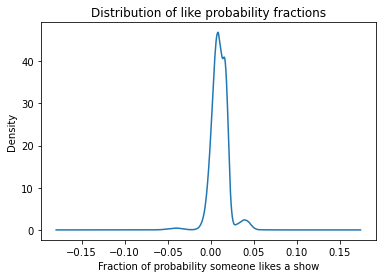

In [24]:
# Determine like probability statistics
min_like_prob = df_show_likelihood.like_probability.min()
max_like_prob = df_show_likelihood.like_probability.max()
mean_like_prob = df_show_likelihood.like_probability.mean()
median_like_prob = df_show_likelihood.like_probability.median()

print("Minimum like probability fraction for a user about a show is: ", min_like_prob)
print("Maximum like probability fraction for a user about a show is: ", max_like_prob)
print("Mean like probability fraction for a user about a show is: ", 
      "{:.0f}".format(mean_like_prob))
print("Median like probability fraction for a user about a show is: ", 
      "{:.0f}".format(median_like_prob))

# Plot distribution of like fractions 
df_show_likelihood.like_probability.plot.kde()
plt.xlabel("Fraction of probability someone likes a show")
plt.title("Distribution of like probability fractions")
plt.show()